In [1]:
# 강화학습 프로그래밍
# 데이터셋?
# (경험 샘플들 -> (s, a, r, s'))
# (s, a, r, s')
# 경험 샘플을 우리가 직접 수집해야 함

# 여태까지 머신러닝 실습 파이프라인
# 데이터셋 수집
# 데이터 전처리
# 모델 선정 (인스턴스 만들고, 하이퍼파라미터 정하고, ...)
# 피팅
# 테스트

In [2]:
# 강화학습 구성 요소
# 에이전트
# 환경
# 1. 에이전트를 우리가 만들고, 미리 만들어져있는 환경 가져다쓰기
# 2. 에이전트는 만들어져있는거 쓰고, 환경은 우리가 만들기 (재활용 로봇 기준 만든 클래스 올려놓기)
# 1번 -> 에이전트의 강화학습 알고리즘을 내가 만든다
# 이 강화학습 알고리즘이 준-표준급의 환경에서 얼마나 잘 작동할까
# 2번 -> 내 수중에 이미 풀고자 하는 문제가 있다
# 이 문제를 MDP로 state diagram 식으로 그린다든지 해서 정의를 하고
# state, action, reward 등
# 예를 들면 tf-agents -> DQN, DDPG, A2C, ...

In [3]:
!pip3 install gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 11.5 MB/s eta 0:00:00


In [4]:
# 환경
import gymnasium as gym
import math, random, matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque # replay buffer에 들어가는 경험 샘플
# 무슨 자료형에 넣는다 (enqueue); 뽑는다 (dequeue)
from itertools import count # product (길이 m 배열, 길이 n 배열)

import torch
import torch.nn as nn # nn.Linear
import torch.optim as optim # keras.optimizers.Adam   SGD
import torch.nn.functional as F # 예) ReLU

In [5]:
env = gym.make("CartPole-v1")

In [6]:
# 보상 그래프 실시간으로 업데이트해서 화면에 띄우기
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion() # interaction ON됐다

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# replay buffer 클래스
# OOP로 정의해야 할 것: 성질, 기능
# 저장소의 크기
# 저장, 샘플링
# object라는 파이썬 기본 base class를 상속 중
Transition = namedtuple("Transition",
                        {"state", "action", "next_state", "reward"})
class ReplayBuffer(object):
  def __init__(self, buffer_size):
    self.buffer = deque([], maxlen=buffer_size)
    return

  def push(self, *args): # argument 갯수를 미리 정해주지 않아도 됨
  # kwargs (keyword arguments: 키워드1=argument1, 키워드2=argument2)
  # ax.plot(x, y, s=3, labels=aldkja, markerfacecolor="black",)
    self.buffer.append(Transition(*args))
    return

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

  def __len__(self): # 얼마나 차있는지
    return len(self.buffer)

In [37]:
# DQN
# 파이토치로 신경망 모델 만들 때
# 공통 상속 클래스 nn.Module

class DQN(nn.Module):
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    # 이하 튜닝 대상
    self.layer1 = nn.Linear(n_observations, 64)
    self.layer2 = nn.Linear(64, 64)
    self.layer3 = nn.Linear(64, n_actions)
    # 이상 튜닝 대상 -> forward 함수도 맞춰서 수정해주기
    return

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x) # 마지막에 나온 값은 이제 logits
    # logits를 sigmoid 통과시키면 "확률"로 해석할 수 있는 합이 1인 값들이 나옴

In [38]:
# 이하 튜닝 대상 (학습 관련 하이퍼파라미터)
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9 # 처음에는 90% 확률로 탐사 (랜덤 액션 취함)
EPS_END = 0.05 # 마지막에는 5% 확률로만 탐사
EPS_DECAY = 1000 # 서서히 낮추기
TAU = 0.005 # target network 업데이트를 서서히 하게
# 슬라이드에서는 일정 주기로 policy network weight를 target network 쪽으로 붙여넣기
# 매 step weight의 일부만을 가중평균 구하기
LR = 5e-4

In [39]:
n_actions = env.action_space.n
state, _ = env.reset()
n_observations = len(state)
n_observations

4

In [40]:
# 네트워크 2개 만들기
# policy network, target network
# same structure
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# state dictionary는 파이토치 모델의 상태들이 기록되어있는 사전
# 최초의 policy->target 카피

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
replay_buffer = ReplayBuffer(10000)

steps_done = 0 # 마친 스텝

In [41]:
# Q-learning, SARSA 실습에서처럼
# - 액션 고르는 함수
# - Q-learn에 해당하는 학습이 진행되는 함수 optimize_model

# - 실시간으로 그래프 그리는 함수

In [42]:
def eps_greedy_action(state):
  global steps_done
  sample = random.random() # epsilon이랑 비교해서 탐사/활용
  # epsilon 천천히 값 낮추기; epsilon schedule / epsilon profile
  eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
  if sample > eps_threshold: # 정책에 의한 액션 선정 (greedy)
    with torch.no_grad():
      return policy_net(state).max(1)[1].view(1,1)
      # max(1)은 폭이 2인 층에서 나온 값 (2,) 중 가장 큰 1개를 뽑겠다 -> 값과 index가 반환됨
      # [1]은 logit 값 말고 큰 1개 값의 위치(index)를 가리킴
      # view는 원본을 건드리지 않은 채로 뷰만 reshape된 채로 제공함
  else: # 랜덤 액션
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    # torch.tensor로 바꿔주자 뭘?
    # 가능한 액션 선택지 중 샘플
    # [[]] 두 겹 의미: 안쪽 건 텐서로 변환하기 위해 필수 (일단 배열이어야 하니까)
    # 바깥쪽 건 배치로 연산되는 병렬 형태 배열

In [43]:
def optimize_model():
  # 만약 배치 사이즈보다 누적된 샘플 갯수가 적으면 아직 학습 안 하기
  if len(replay_buffer) < BATCH_SIZE:
    return

  transitions = replay_buffer.sample(BATCH_SIZE) # (s, a, r, s') 샘플을 배치 사이즈 개 뽑기

  batch = Transition(*zip(*transitions))
  # zip은 s끼리 a끼리... 모아줌
  # 모아서 batch라는 이름의 namedtuple로 만들면
  # BATCH_SIZE개의 state에 한번에 batch.state 라고 접근 가능

  state_batch = torch.cat(batch.state) # cat은 concatenate: 이어붙이기
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)
  # next state는 약간의 후처리가 좀 필요
  # MC든 TD든 terminal_state에 대해서는 가치가 0이었음
  # terminal인지를 boolean array masking으로 구분해주기
  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
  # lambda 익명 함수: s를 입력으로 받아 s가 terminal state가 아니면 True를 반환
  # map 함수는 첫번째 인자 (즉, 익명함수)를 두번째 인자 (즉, 배열) 에 각각 적용
  # 그렇게 반환된 True, False, ...등을 튜플로 캐스팅
  # 그 튜플을 텐서로 캐스팅
  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

  # q값
  # Q(s, a) = Q(s, a) + LR * [reward + GAMMA*max(Q(s', a)) - Q(s, a)]
  state_action_values = policy_net(state_batch).gather(1, action_batch)
  next_state_values = torch.zeros(BATCH_SIZE, device=device)
  with torch.no_grad(): # target network 활용할 거임 근데 기울기 계산 안 하기
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
  # TD target 계산
  TD_target = reward_batch + (GAMMA * next_state_values)

  # Huber loss (강화학습에서 널리 쓰이는 손실함수)
  criterion = nn.SmoothL1Loss()
  loss = criterion(state_action_values, TD_target.unsqueeze(1))
  # criterion 사용 문법은 sklearn.metrics.accuracy 떠올리면 됨
  # squeeze 길이 1인 축을 없앰
  # unsqueeze 하면서 인자를 1로 주면 0번째 축을 만들어서 BATCH_SIZE가 오도록 함
  # 원래 배열은 1번째 축으로 "이동"

  # 파이토치 역전파
  optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
  # gradient clipping: 기울기가 너무 큰 값이 아니도록 -> 학습이 안정적이 되도록
  optimizer.step()
  return

In [44]:
# 그래프 그리는 함수 적어놓기
# 강화학습 커스텀 환경 만드는 내용 올려놓기
# 트레이닝 루프 내일 수업에서


episode_durations = [] # 각 에피소드의 길이(스텝 기준)를 저장


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [45]:
# GPU 활용 가능 여부에 따라 학습 길이 나누기
if torch.cuda.is_available():
  num_episodes = 600
else:
  num_episodes = 50

In [46]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)

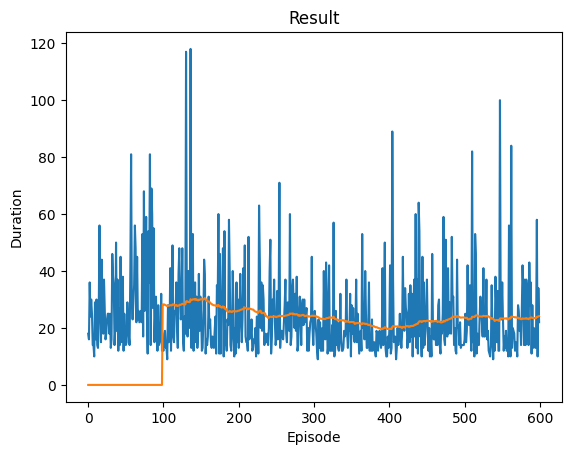

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [47]:
# 트레이닝 루프
for i_episode in range(num_episodes):
  # 초기화 # 알고리즘 상자에서는 Initialize S 이런식으로 표기됨
  state, _ = env.reset()
  # 텐서로 캐스팅
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
  # numpy newaxis와 비슷하게 unsqueeze로 새 축 만들기 -> 왜? batch_size 가 들어갈 축
  # 인자로 들어오는 정수 축 순번에 새 축을 만듦
  # 0이라 하면, 0번째 축을 새로 만들고 나머지들이 하나씩 밀려남

  # step마다
  for t in count():
    # Q-learning 내용 그대로 따라가면 됨
    # 중간중간 텐서 캐스팅이 들어가있음
    action = eps_greedy_action(state)
    # 고른 액션 취해서 한 RL step 밟기
    observation, reward, terminated, truncated, _ = env.step(action.item())
    # item? pandas dataframe -> 텐서에서 값 자체(int / float)만 취할 때
    # observation: next_state
    # reward: 보상
    # terminated: 너무 많이 기울어지거나, 카트가 화면 밖으로 나가면 True
    # truncated: 500스텝에 도달하면 True
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
      next_state = None
    else:
      next_state = torch.tensor(observation, device=device, dtype=torch.float32).unsqueeze(0)

    # (s, a, r, s')가 만들어지면 이걸로 바로 학습했었음 (Q-learning, SARSA 실습 참고)
    # 온라인 러닝
    # 학습의 안정성을 위해 replay buffer에 일단 넣어두기
    replay_buffer.push(state, action, next_state, reward)
    state = next_state

    optimize_model() # Q_learn() SARSA()

    # target network로 카피하기
    # weighted average로 서서히 움직이게끔
    target_net_weights = target_net.state_dict()
    policy_net_weights = policy_net.state_dict()
    for key in policy_net_weights:
      target_net_weights[key] = policy_net_weights[key] * TAU + target_net_weights[key] * (1 - TAU)
    target_net.load_state_dict(target_net_weights)

    # 에피소드 끝나면
    if done:
      episode_durations.append(t + 1) # 이걸로 그래프 그리려고
      plot_durations()
      break # 안쪽 루프에서 나오는 break (for t in count())

plot_durations(show_result=True)
plt.ioff() # interaction모드 끄겠다
plt.show()